In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def display(image, cmap = 'gray'):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap)

In [29]:
################################################################################################
## Watershed Algorithm 작동 순서                                                              ##
##  1. 이미지 조회                                                                            ##
##  2. 이미지 블러 처리                                                                       ##
##  3. 흑백 + 바이너리화 (cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)                            ##
##  4. (옵션) 이미지 커널을 이용한 침식 후 opening 생성                                       ##
##  5. 확실한 배경 탐색 (cv2.dialate(opnening, kenrel, iteration = 3))                        ##
##  6. 전경 탐색을 위한 거리 측정 (cv2.distanceTrnasform(opening, cv2.DIST_L2, 5))            ##
##  7. 흑백 + 바이너리화 (cv2.trheshold(dist_transform, 0.7 * dist_trasnform.max(), 255, 0))  ##
##  8. 확실한 전경 탐색 (cv2.substract(nsure_bg, np.uint8(sure_fg)))                          ##
##  9. 마커 생성 (cv2.connectedComponents(sure_fg))                                           ##
## 10. Watershed 적용 (cv2.watershed(image, markers))                                         ##
## 11. Contour Detection 적용 (cv2.findContours + cv2.drawContours)                           ##
################################################################################################

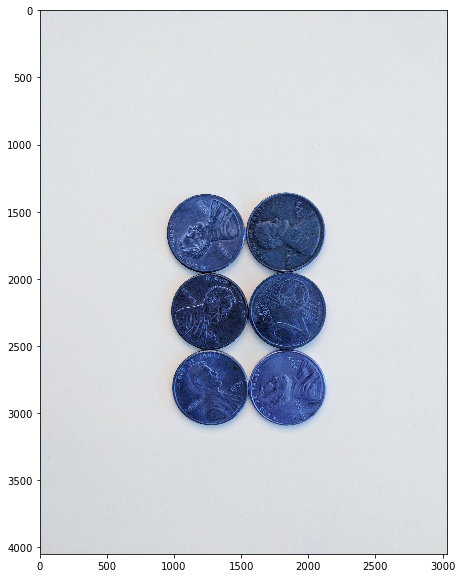

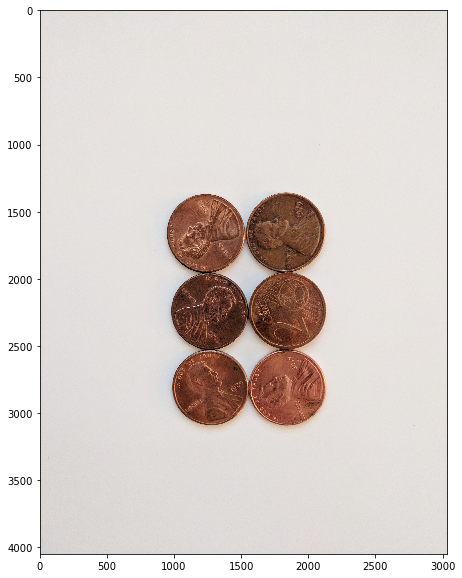

In [27]:
image = cv2.imread('../../DATA/pennies.jpg')
cvt_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
display(image)
display(cvt_image)

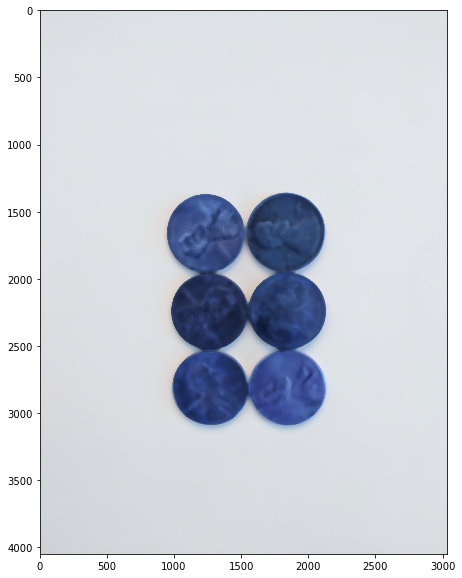

In [5]:
blurred_image = cv2.medianBlur(image, 35)
display(blurred_image)

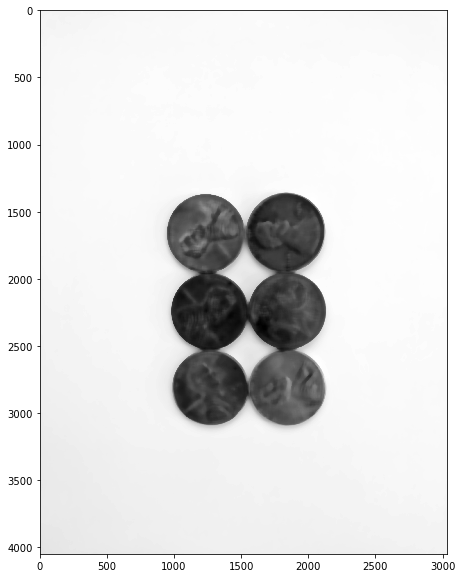

In [6]:
gray_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)
display(gray_image)

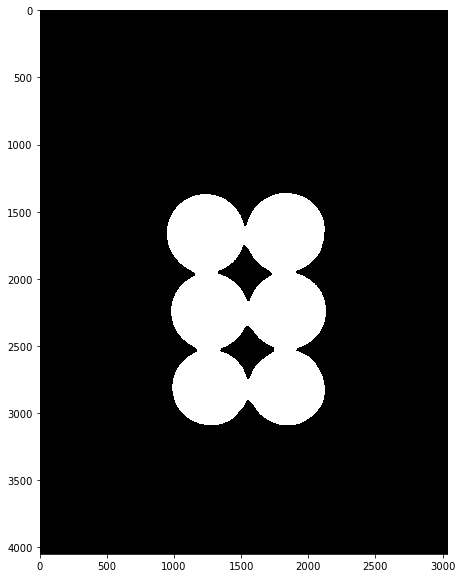

In [7]:
###################################################################
## Otsu's method : https://en.wikipedia.org/wiki/Otsu%27s_method ##
###################################################################

###########################################################################################################
## before : ret, threshold = cv2.threshold(gray_image, 160, 255, cv2.THRESH_BINARY_INV)                  ##
## after  : ret, threshold = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  ##
###########################################################################################################

ret, threshold = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
display(threshold)

In [8]:
##############################
## Noise Removal (optional) ##
##############################

kernel = np.ones((3, 3), np.uint8)
kernel

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)

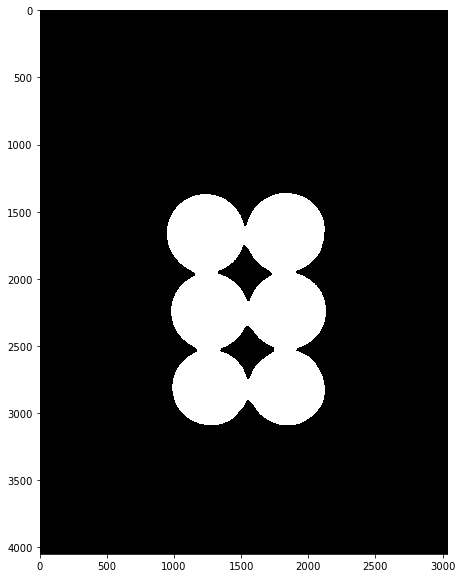

In [9]:
opening = cv2.morphologyEx(
    threshold,
    cv2.MORPH_OPEN,
    kernel,
    iterations = 2
)
display(opening)

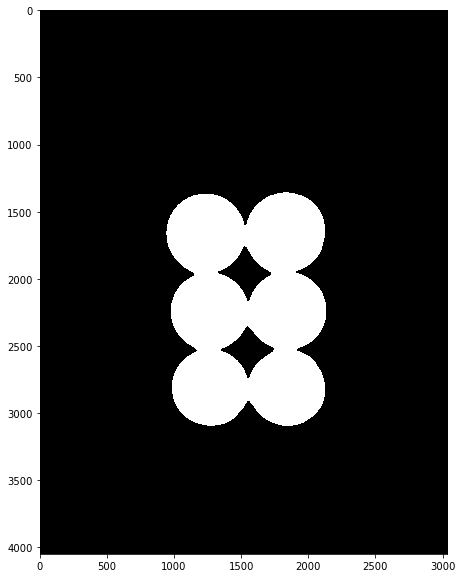

In [10]:
# sure background area
sure_background = cv2.dilate(opening,kernel,iterations=3)
display(sure_background)

In [11]:
###########################################################################
## Distance Transform : https://en.wikipedia.org/wiki/Distance_transform ##
###########################################################################

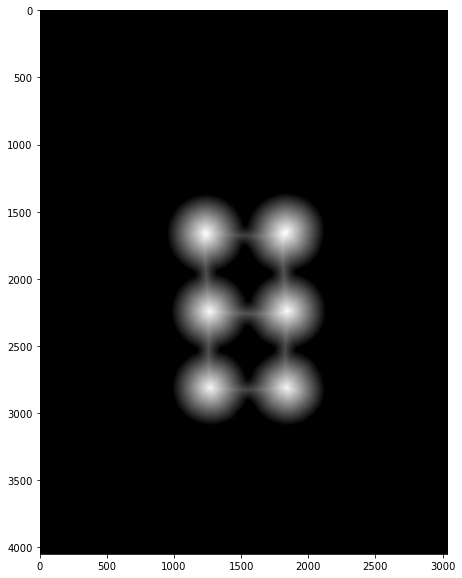

In [12]:
dist_transform = cv2.distanceTransform(
    opening,
    cv2.DIST_L2,
    5, # Mask  Size
)
display(dist_transform)

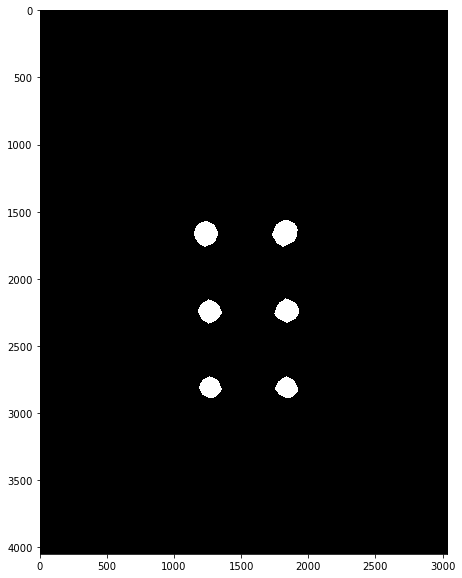

In [13]:
ret, sure_foreground = cv2.threshold(
    dist_transform,
    0.7 * dist_transform.max(),
    255,
    0
)
display(sure_foreground)

In [14]:
sure_foreground = np.uint8(sure_foreground)

In [15]:
unkown = cv2.subtract(sure_background, sure_foreground)

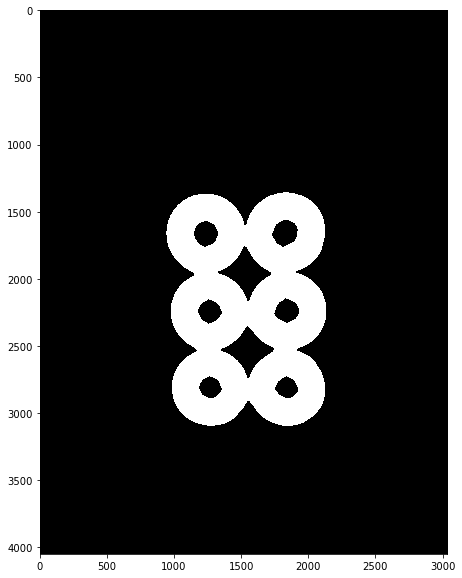

In [16]:
display(unkown)

In [17]:
##################
## Label Marker ##
##  1.          ##
##  2.          ##
##  3.          ##
##################

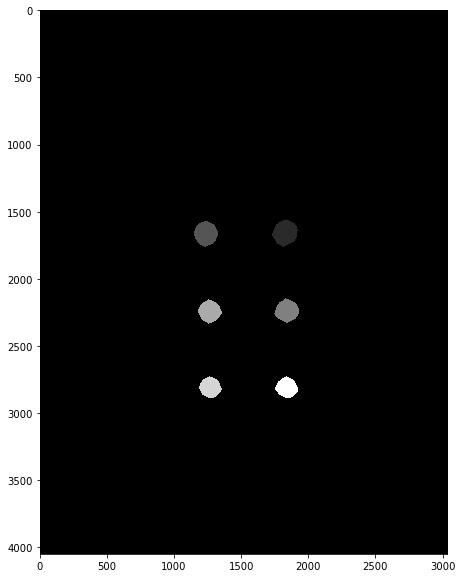

In [18]:
ret, markers = cv2.connectedComponents(
    sure_foreground
)
display(markers)

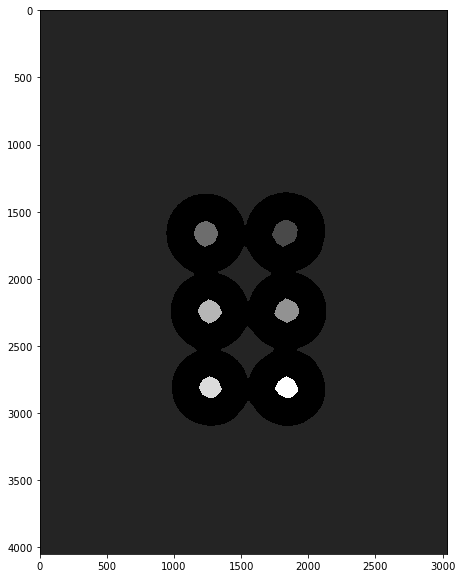

In [19]:
markers = markers + 1
markers[unkown == 255] = 0
display(markers)

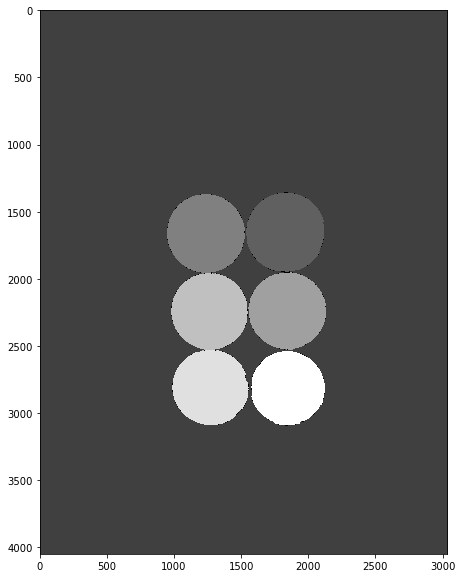

In [20]:
markers = cv2.watershed(image, markers)
display(markers)

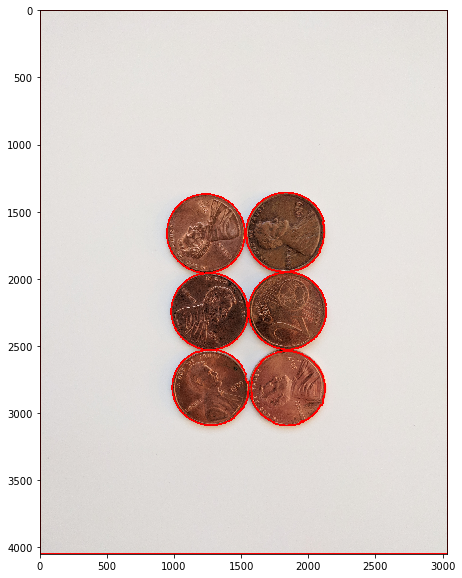

In [28]:
image, contours, hierarchy = cv2.findContours(
    markers.copy(),
    cv2.RETR_CCOMP,
    cv2.CHAIN_APPROX_SIMPLE
)

for i in range(len(contours)):
    
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(
            cvt_image,
            contours,
            i,
            (255, 0, 0),
            10
        )
display(cvt_image)